In [1]:
%matplotlib notebook
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurements', 'stations']

In [8]:
# Save references to each table
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


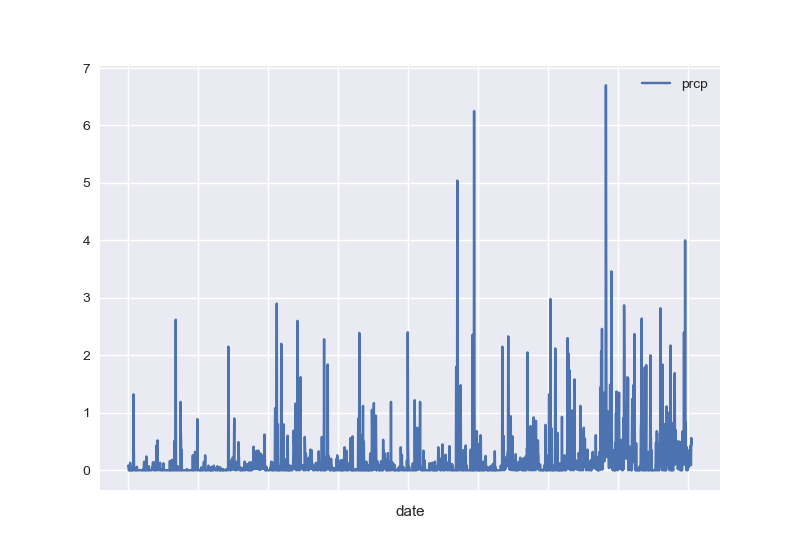

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
    
# Calculate the date 1 year ago from today
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date > year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(data=precipitation)
precipitation_df = precipitation_df.set_index('date')
# Sort the dataframe by date
precipitation_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.savefig("Resources/prcp.png")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
stations = session.query(Station.station).count()
print(f"There are {stations} stations.")

There are 9 stations.


In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
for station in active:
    print(f"{station[0]} with {station[1]} entries.")

USC00519281 with 2772 entries.
USC00513117 with 2696 entries.
USC00519397 with 2685 entries.
USC00519523 with 2572 entries.
USC00516128 with 2484 entries.
USC00514830 with 1937 entries.
USC00511918 with 1932 entries.
USC00517948 with 683 entries.
USC00518838 with 342 entries.


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(Measurement.station, func.count(Measurement.station), func.min(Measurement.tobs),\
    func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
print(f"{temp[0]}:")
print(f"Number of entries: {temp[1]}")
print(f"Lowest Temperature: {temp[2]}")
print(f"Highest Temperature: {temp[3]}")
print(f"Average Temperature: {temp[4]}")

USC00519281:
Number of entries: 2772
Lowest Temperature: 54
Highest Temperature: 85
Average Temperature: 71.66378066378067


In [15]:
# Choose the station with the highest number of temperature observations.
largest_data_station = session.query(func.count(Measurement.tobs), Measurement.station).\
    filter(Measurement.date > year_ago).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
largest_data_station

(358, 'USC00519397')

<IPython.core.display.Javascript object>


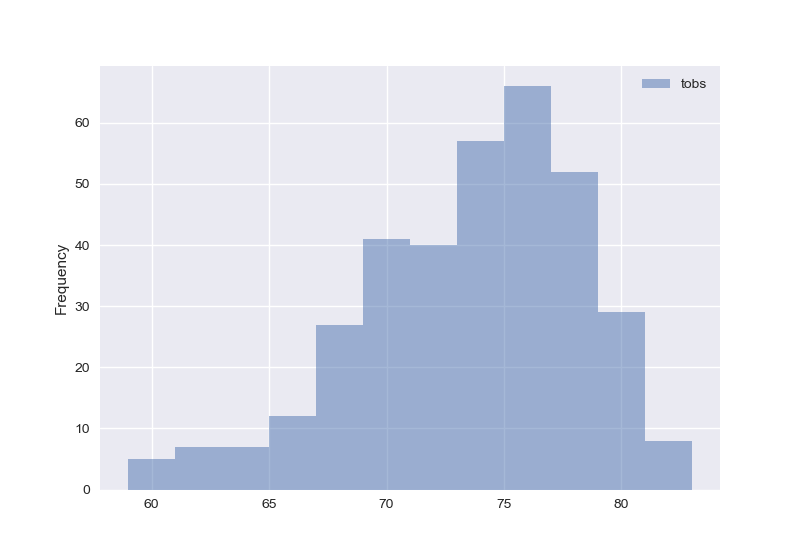

In [16]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = session.query(Measurement.date).\
    filter(Measurement.station == largest_data_station[1]).\
    order_by((Measurement.date).desc()).first()
year_tobs = session.query(Measurement.tobs, Measurement.date).\
    filter(Measurement.station == temp[0]).\
    filter(Measurement.date > year_ago).\
    order_by((Measurement.date).desc()).all()

tobs_df = pd.DataFrame(data=year_tobs)
# Use Pandas Plotting with Matplotlib to plot the data
ax = tobs_df.plot.hist(bins=12, alpha=0.5)
plt.savefig("Resources/tobs.png")

In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2016-7-1','2017-7-1')
trip_data

[(58, 74.02052091554854, 87)]

<IPython.core.display.Javascript object>


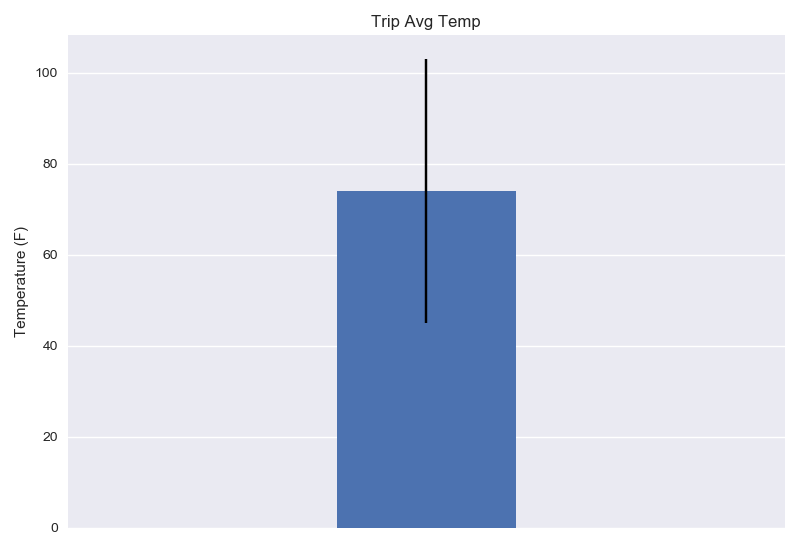

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp  = trip_data[0][1]
peak_to_peak = trip_data[0][2] - trip_data[0][0]
fig, ax = plt.subplots()
ax.bar(0, avg_temp, width=0.10, yerr=peak_to_peak)
ax.set_ylabel('Temperature (F)')
ax.set_title('Trip Avg Temp')
plt.xlim(-.2, .2)
plt.xticks([])
fig.tight_layout()
plt.savefig("Resources/trip_avg_temp.png")
plt.show()

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start = dt.date(2017,7,1)
year_before_trip = trip_start - dt.timedelta(days=365)
sel = [func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_year_rainfall = session.query(*sel).\
    filter(Measurement.date >= year_before_trip).filter(Measurement.date <= trip_start).\
    filter(Station.station == Measurement.station).group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
largest_data_station

for record in station_year_rainfall:
    (prcp, station, name, lat, long, elev) = record
    print(f"Annual Rainfall ending {trip_start} for {station}: {prcp}\x22")
    print(f"{name} is at {lat}\xb0 {long}\xb0 at an elevation of {elev}m")
    print("")

Annual Rainfall ending 2017-07-01 for USC00516128: 165.9499999999999"
MANOA LYON ARBO 785.2, HI US is at 21.3331° -157.8025° at an elevation of 152.4m

Annual Rainfall ending 2017-07-01 for USC00519281: 92.60000000000007"
WAIHEE 837.5, HI US is at 21.45167° -157.84888999999995° at an elevation of 32.9m

Annual Rainfall ending 2017-07-01 for USC00513117: 63.04000000000005"
KANEOHE 838.1, HI US is at 21.4234° -157.8015° at an elevation of 14.6m

Annual Rainfall ending 2017-07-01 for USC00519523: 45.43"
WAIMANALO EXPERIMENTAL FARM, HI US is at 21.33556° -157.71139° at an elevation of 19.5m

Annual Rainfall ending 2017-07-01 for USC00514830: 34.29"
KUALOA RANCH HEADQUARTERS 886.9, HI US is at 21.5213° -157.8374° at an elevation of 7.0m

Annual Rainfall ending 2017-07-01 for USC00519397: 23.110000000000003"
WAIKIKI 717.2, HI US is at 21.2716° -157.8168° at an elevation of 3.0m

Annual Rainfall ending 2017-07-01 for USC00517948: 5.27"
PEARL CITY, HI US is at 21.3934° -157.9751° at an elevati

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.strftime("%m-%d", Measurement.date), func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[('01-01', 62, 69.06, 77)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = dt.date(2017,7,1)
end_date = dt.date(2017,7,8)
# Use the start and end date to create a range of dates
dates_range = pd.date_range(start_date, end_date)
# Strip off the year and save a list of %m-%d strings
dates_range = dates_range.strftime("%m-%d")
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in dates_range:
    normals.append(*daily_normals(date))
normals

[('07-01', 68, 74.95833333333333, 81),
 ('07-02', 68, 75.16666666666667, 82),
 ('07-03', 68, 74.80851063829788, 82),
 ('07-04', 70, 76.57446808510639, 81),
 ('07-05', 66, 74.61224489795919, 81),
 ('07-06', 69, 74.71153846153847, 81),
 ('07-07', 69, 74.62, 82),
 ('07-08', 69, 75.6, 81)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=["date","tmin","tavg","tmax"])
normals_df = normals_df.set_index('date')
normals_df

,tmin,tavg,tmax
date,,,
07-01,68,74.958333,81
07-02,68,75.166667,82
07-03,68,74.808511,82
07-04,70,76.574468,81
07-05,66,74.612245,81
07-06,69,74.711538,81
07-07,69,74.620000,82
07-08,69,75.600000,81


<IPython.core.display.Javascript object>


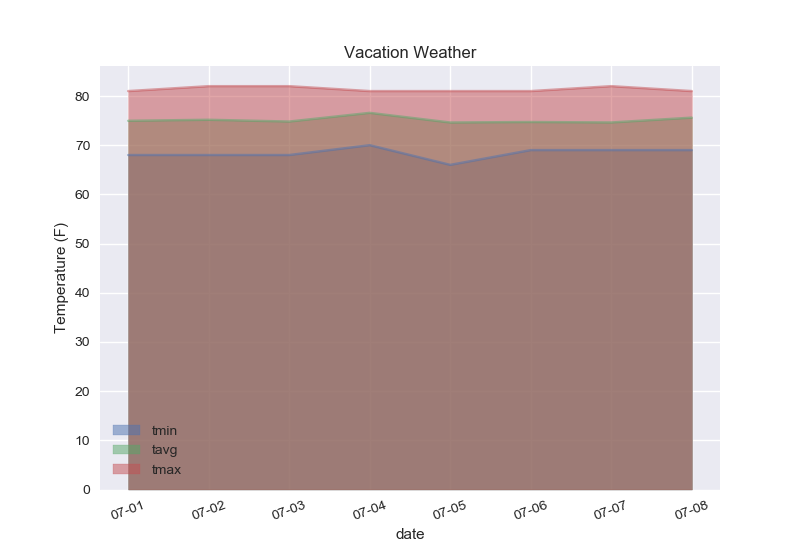

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot(kind='area', stacked=False, title='Vacation Weather')
ax.set_ylabel('Temperature (F)')
plt.xticks(np.arange(len(dates_range)), dates_range, rotation=20)
plt.savefig("Resources/vacation_weather.png")
plt.show()